In [131]:
import pandas as pd
import numpy as np 
import os

import matplotlib.pyplot as plt
import matplotlib.cm 
import matplotlib.colors
from matplotlib.patches import Patch
plt.rcParams['font.family'] = 'Arial'

from selenobot.files import FASTAFile
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
import re
from fabapi import Query
from tqdm import tqdm 
from scipy.stats import mannwhitneyu

%load_ext autoreload
%autoreload 2

types = ['plm', 'aa_1mer', 'aa_2mer', 'len']


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# For the sake of speeding things up, going to use a subset of GTDB genomes. I will grab the highest-completion representative
# genome from each bacterial phylum. 
metadata_df = pd.read_csv('../data/bac120_metadata_r207.tsv', delimiter='\t')
metadata_df = metadata_df[bacteria_metadata_df.gtdb_representative == 't'] # Get the representatives. 
# Extract the phylum... 
phylum = [re.search(r'p__([^;]+);', taxonomy).group(1) for taxonomy in bacteria_metadata_df.gtdb_taxonomy]
bacteria_metadata_df['phylum'] = phylum

print('Number of representative genomes:', len(bacteria_metadata_df))
print('Number of phyla:', len(np.unique(phylum)))

subset_df = [] # For storing the genome from each phylum with the highest completeness.. 
for _, phylum_df in bacteria_metadata_df.groupby('phylum'):
    phylum_df = phylum_df.sort_values('checkm_completeness', ascending=False)
    subset_df.append(phylum_df.iloc[0].copy())
subset_df = pd.DataFrame(subset_df)

# Remove the prefixes from the genome IDs. 
subset_df = subset_df.rename(columns={'accession':'genome_id'})
subset_df.genome_id = [genome_id.replace('GB_', '').replace('RS_', '') for genome_id in subset_df.genome_id]
subset_df.set_index('genome_id').to_csv('../data/bac120_metadata_r207_subset.csv')

In [ ]:
# os.chdir('../scripts')

# ! python predict.py --input-path ../data/bac120_proteins_r207_subset_max_length_2000.h5 --type plm --n-classes 3 --add-metadata
# ! python predict.py --input-path ../data/bac120_proteins_r207_subset_max_length_2000.h5 --type aa_1mer --n-classes 3 --add-metadata
# ! python predict.py --input-path ../data/bac120_proteins_r207_subset_max_length_2000.h5 --type aa_2mer --n-classes 3 --add-metadata
# ! python predict.py --input-path ../data/bac120_proteins_r207_subset_max_length_2000.h5 --type len --n-classes 3 --add-metadata

# ! python predict.py --input-path ../data/bac120_proteins_r207_subset_max_length_2000.h5 --type plm --n-classes 2 --add-metadata
# ! python predict.py --input-path ../data/bac120_proteins_r207_subset_max_length_2000.h5 --type aa_1mer --n-classes 2 --add-metadata
# ! python predict.py --input-path ../data/bac120_proteins_r207_subset_max_length_2000.h5 --type aa_2mer --n-classes 2 --add-metadata
# ! python predict.py --input-path ../data/bac120_proteins_r207_subset_max_length_2000.h5 --type len --n-classes 2 --add-metadata

In [ ]:
types = ['plm']

gtdb_ternary_results = dict()
gtdb_binary_results = dict()

for type_ in types:
    ternary_results_df = pd.read_csv(f'../data/results/predict_bac120_proteins_r207_subset_max_length_2000_ternary_model_{type_}.csv', index_col=0, dtype={'partial':str})
    ternary_results_df = ternary_results_df[ternary_results_df.partial.str.match('00')]
    gtdb_ternary_results[type_] = ternary_results_df

    binary_results_df = pd.read_csv(f'../data/results/predict_bac120_proteins_r207_subset_max_length_2000_binary_model_{type_}.csv', index_col=0, dtype={'partial':str})
    binary_results_df = binary_results_df[binary_results_df.partial.str.match('00')]
    gtdb_binary_results[type_] = binary_results_df

In [111]:
# What were the sequences predicted to be selenoproteins by the binary model predicted to be by the ternary model?
gtdb_binary_results_plm_df = gtdb_binary_results['plm']
gtdb_ternary_results_plm_df = gtdb_ternary_results['plm']

print('Binary model results (plm)')
print('Label 1:', (gtdb_binary_results_plm_df.prediction == 1).sum())
print('Label 0:',(gtdb_binary_results_plm_df.prediction == 0).sum())
print()
print('Ternary model results (plm)')
print('Label 2:', (gtdb_ternary_results_plm_df.prediction == 2).sum())
print('Label 1:', (gtdb_ternary_results_plm_df.prediction == 1).sum())
print('Label 0:', (gtdb_ternary_results_plm_df.prediction == 0).sum())
print()

binary_predicted_label_1 = gtdb_binary_results_plm_df[gtdb_binary_results_plm_df.prediction == 1].index
ternary_predicted_label_1 = gtdb_ternary_results_plm_df[gtdb_ternary_results_plm_df.prediction == 1].index

Binary model results (plm)
Label 1: 18095
Label 0: 442632

Ternary model results (plm)
Label 2: 27926
Label 1: 12234
Label 0: 420567



In [40]:
# Ger copy number and such from Find-A-Bug. 
SELD_KO = 'K01008' 
SELA_KO = 'K01042' 
SELB_KO = 'K03833' 

def get_sel_genes(genome_ids:list, output_path:str='../data/proteins_r207_subset_max_length_2000_sel_genes.csv'):

    sel_genes_df = []
    # for genome_id in tqdm(genome_ids, desc='get_sel_genes: Retrieving genome copy numbers...'):
    #     query = Query('annotations_kegg')
    #     # query.equal_to('ko', [SELB_KO])
    #     query.equal_to('genome_id', genome_id) # Hopefully don't need to paginate if I filter by genome.
    #     sel_genes_df.append(query.get(print_url=True))

    # sel_genes_df = pd.concat(sel_genes_df)
    # sel_genes_df = sel_genes_df.set_index('genome_id')
    # sel_genes_df.to_csv(output_path)
    if os.path.exists(output_path):
        return pd.read_csv(output_path, index_col=0)

    annotations_dir = '../data/bac120_proteins_r207_subset_annotations_kegg'
    for file_name in tqdm(os.listdir(annotations_dir), desc='get_sel_genes'):
        path = os.path.join(annotations_dir, file_name)
        df = pd.read_csv(path, comment='#', names=['meets_threshold', 'id', 'ko', 'threshold', 'score', 'e_value', 'definition'], delimiter='\t', low_memory=False)
        df = df[df.ko.isin([SELA_KO, SELB_KO, SELD_KO])]
        df['genome_id'] = re.match(r'(GB|RS)_(.+)_protein.ko.tab', file_name).group(2)
        sel_genes_df.append(df)

    sel_genes_df = pd.concat(sel_genes_df).set_index('id')
    sel_genes_df['meets_threshold'] = ~sel_genes_df.meets_threshold.isnull()
    sel_genes_df.to_csv(output_path)
    return sel_genes_df


In [ ]:
metadata_df = pd.read_csv('../data/bac120_metadata_r207.tsv', delimiter='\t', low_memory=False).rename(columns={'accession':'genome_id'})
metadata_df.genome_id = metadata_df.genome_id.apply(lambda genome_id : re.match(r'(GB|RS)_(.+)', genome_id).group(2))
metadata_df = metadata_df.set_index('genome_id')

In [112]:

# genome_ids = pd.read_csv('../data/bac120_proteins_r207_subset_max_length_2000.csv', index_col=0).genome_id.unique()
# print(len(genome_ids), 'genome IDs in the GTDB subset.')
sel_genes_df = get_sel_genes(genome_ids)
sel_genes_df = sel_genes_df[sel_genes_df.meets_threshold]

copy_numbers_df = []
for genome_id, genome_df in sel_genes_df.groupby('genome_id'):
    counts = genome_df.value_counts('ko').to_dict()
    counts['genome_id'] = genome_id
    copy_numbers_df.append(counts)

copy_numbers_df = pd.DataFrame(copy_numbers_df).set_index('genome_id').fillna(0)
copy_numbers_df = copy_numbers_df.rename(columns={SELA_KO:'sel_a_copy_number', SELB_KO:'sel_b_copy_number', SELD_KO:'sel_d_copy_number'})

binary_hits_per_genome = gtdb_binary_results_plm_df[gtdb_binary_results_plm_df.prediction == 1].groupby('genome_id').apply(len, include_groups=False)
binary_hits_per_genome.name = 'n_hits_binary_model'
ternary_hits_per_genome = gtdb_binary_results_plm_df[gtdb_binary_results_plm_df.prediction == 1].groupby('genome_id').apply(len, include_groups=False)
ternary_hits_per_genome.name = 'n_hits_ternary_model'

copy_numbers_df = copy_numbers_df.merge(binary_hits_per_genome, right_index=True, left_index=True, how='outer').fillna(0)
copy_numbers_df = copy_numbers_df.merge(ternary_hits_per_genome, right_index=True, left_index=True, how='outer').fillna(0)
# Also need to add the total number of genes to the DataFrame... 
copy_numbers_df = copy_numbers_df.merge(metadata_df[['genome_size']], left_index=True, right_index=True, how='left')

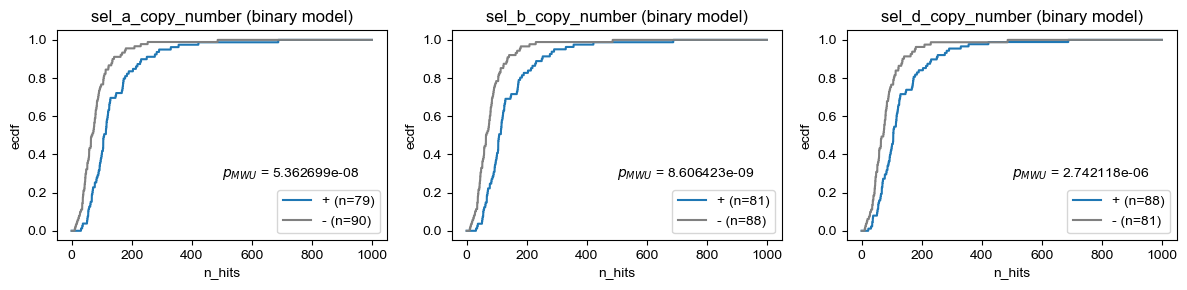

In [145]:
fig, axes = plt.subplots(figsize=(12, 3), ncols=3)

# ax.scatter(copy_numbers_df.n_hits, copy_numbers_df.sel_a_copy_number)

def plot_ecdf(values:pd.DataFrame, ax:plt.Axes=None, max_x_value:float=None, color:str='tab:blue'):
    x_vals = np.linspace(0, max_x_value, 10000)
    n = len(values)
    y_vals = [np.sum(values < x) / n for x in x_vals]
    ax.plot(x_vals, y_vals, lw=1.5, c=color)


for col, ax in zip(['sel_a_copy_number', 'sel_b_copy_number', 'sel_d_copy_number'], axes):
    pos_df = copy_numbers_df[copy_numbers_df[col] > 0]
    neg_df = copy_numbers_df[copy_numbers_df[col] < 1]
    
    model_type = 'binary'

    plot_ecdf(pos_df[f'n_hits_{model_type}_model'], ax=ax, max_x_value=1000, color='tab:blue')
    plot_ecdf(neg_df[f'n_hits_{model_type}_model'], ax=ax, max_x_value=1000, color='gray')
    mwu_result = mannwhitneyu(pos_df[f'n_hits_{model_type}_model'], neg_df[f'n_hits_{model_type}_model'])
    # print(f'Mann-Whitney U test p-value for {col}:', mwu_result.pvalue)
    # print(f'Mann-Whitney U test statistic for {col}:', mwu_result.statistic)
    ax.text(0.5, 0.3, r"$p_{MWU}$ = " + '{:e}'.format(mwu_result.pvalue), transform=ax.transAxes)

    ax.set_title(f'{col} ({model_type} model)')
    ax.legend([f'+ (n={len(pos_df)})', f'- (n={len(neg_df)})'])
    ax.set_ylabel('ecdf')
    ax.set_xlabel('n_hits')

plt.tight_layout()
plt.show()

# The Mann-Whitney U-test can be used to test whether there is a difference between two groups, without relying
# on the data being normally-distributed (it's a non-parametric test). Looks at the rank-sum (should probably look into this more)
# https://stats.stackexchange.com/questions/252976/mann-whitney-u-statistic-seems-very-large-is-something-wrong

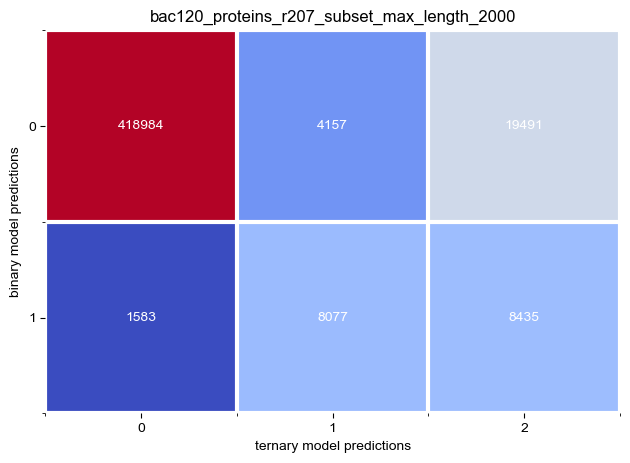

In [135]:

fig, ax = plt.subplots()
ax.set_yticks([0, 1]) # , labels=['fl', 'ts'])
ax.set_ylabel('binary model predictions')
ax.set_xticks([0, 1, 2]) # , labels=['fl', 'ts', 'tns'])
ax.set_xlabel('ternary model predictions')
ax.set_title('bac120_proteins_r207_subset_max_length_2000')

data = np.zeros((2, 3))
for binary_prediction, ternary_prediction in zip(gtdb_binary_results_plm_df.prediction, gtdb_ternary_results_plm_df.prediction):
    data[binary_prediction, ternary_prediction] += 1


ax.imshow(np.log(sizes), cmap='coolwarm') #, norm=norm)
ax.spines[:].set_visible(False)
# NOTE: What does shifting the ticks by 0.5 to the left do? Ah it's because of where the square boundaries are. 
ax.set_xticks(np.arange(data.shape[1] + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(data.shape[0] + 1) - 0.5, minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=3)

for x in range(3):
    for y in range(2):
        text = ax.text(x, y, int(sizes[y, x]), ha='center', va='center', color='w')

plt.tight_layout()
plt.show()

# Based on the plot below, it seems as though the ternary model has a tendency to predict full-length
# sequences to be truncated non-selenoproteins. The ternary model also has the tendency to categorize truncated selenoproteins as 
# truncated non-selenoproteins. Both generally agree on the full-length sequences. 

I need to brainstorm a good way to look for interesting hits, as there must be a lot of false positives. I doubt that there are any genomes with hundreds of selenoproteins. It would also be good to figure out exactly why the model is flagging so many sequences; based on the results of the ternary classifier, it doesn't necessarily seem to be the case that all of the things which are being flagged are truncated non-selenoproteins. Perhaps they are simply spurious sequences?

I could try annotating protein domains to see if the hits have anything interesting. 

1497
1497
859


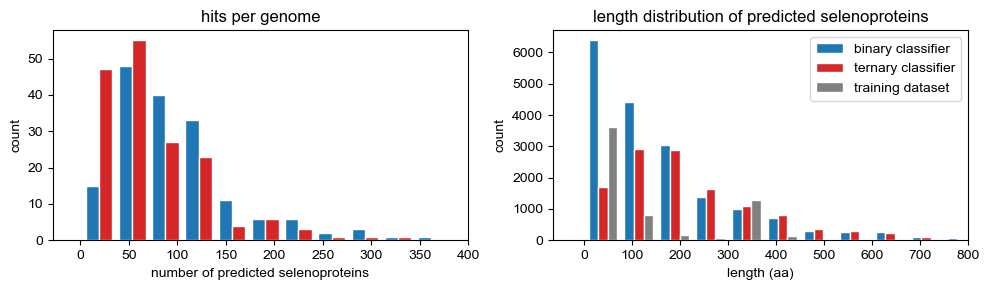

In [157]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 3))

hits_per_genome = []
lengths = []
legend = []


for df in [gtdb_binary_results['plm'], gtdb_ternary_results['plm']]:
    hits_per_genome.append(df[df.prediction == 1].groupby('genome_id').apply(len, include_groups=False))
    lengths.append(df[df.prediction == 1].length)

train_metadata_df = pd.read_csv('../data/train.csv', index_col=0)
lengths.append(train_metadata_df[train_metadata_df.label == 1].seq.apply(len))

axes[0].hist(hits_per_genome, bins=20, color=['tab:blue', 'tab:red'], edgecolor='white')
axes[0].set_xlabel('number of predicted selenoproteins')
axes[0].set_ylabel('count')
axes[0].set_title('hits per genome')

# length_distribution.append(gtdb_results['plm'].length) # Add the background length distribution. 
for x in lengths:
    print(max(x))
axes[1].hist(lengths, bins=20, color=['tab:blue', 'tab:red', 'gray'], edgecolor='white')
axes[1].legend(['binary classifier', 'ternary classifier', 'training dataset'])

axes[1].set_xlabel('length (aa)')
axes[1].set_ylabel('count')
axes[1].set_title('length distribution of predicted selenoproteins')
axes[1].legend(['binary classifier', 'ternary classifier', 'training dataset'])

# This crops off some outliers... good to keep that in mind. 
axes[1].set_xlim(xmax=800)
axes[0].set_xlim(xmax=400)

plt.tight_layout()
plt.show()
# Binary classifier seems to be picking up many more of the super short sequences as truncated selenoproteins.  